Both robot_arm_gym.py and trajectories.py need to be placed in the same folder as this file.

In [1]:
import os
import gym
import robot_arm_gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from trajectories import Trajectories
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_envs = gym.envs.registry.values()
env_ids = [env_spec.id for env_spec in all_envs]
print(sorted(env_ids))

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'Blackjack-v1', 'CarRacing-v2', 'CartPole-v0', 'CartPole-v1', 'CliffWalking-v0', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Pusher-v2', 'Pusher-v4', 'Reacher-v2', 'Reacher-v4', 'RobotArm-v0', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Taxi-v3', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4']


Look for RobotArm-v0 in the above defined environments to ensure it has been properly registered.

In [2]:
class Value(nn.Module):
    def __init__(self, latent_space_size = 66):
        super(Value,self).__init__()

        self.layer1 = nn.Linear(11, latent_space_size)
        self.layer2 = nn.Linear(latent_space_size,latent_space_size)
        self.output = nn.Linear(latent_space_size,1)
    
    def forward(self,state):
        x = torch.tanh(self.layer1(state))
        x = torch.tanh(self.layer2(x))
        out = self.output(x)

        return out
    
class Policy(nn.Module):
    def __init__(self, latent_space_size = 66):
        super(Policy,self).__init__()
        self.layer1 = nn.Linear(11, latent_space_size)
        self.layer2 = nn.Linear(latent_space_size,latent_space_size)
        self.output = nn.Linear(latent_space_size,5)
        self.output_std = nn.Linear(latent_space_size,5)
    
    def forward(self,state):
        x = torch.tanh(self.layer1(state))
        x = torch.tanh(self.layer2(x))
        mean = torch.sigmoid(self.output(x))
        mean = (mean * 2) - 1
        std = torch.sigmoid(self.output_std(x))
        
        return mean, std

class PPOAgent:
    def __init__(self, env, batch_size, gamma, lamb, epsilon, latent_space_size = 66, device='cpu', seed=0,):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.lamb = lamb
        self.epsilon = epsilon
        self.device = device
        self.seed = seed
        torch.manual_seed(self.seed)

        self.value_net = Value(latent_space_size = latent_space_size)
        self.policy_net = Policy(latent_space_size = latent_space_size)
        self.old_policy_net = Policy(latent_space_size = latent_space_size)
        self.old_policy_net.load_state_dict(self.policy_net.state_dict())

    def train(self, nr_episodes, nr_epochs, policy_adam_params, value_adam_params):
        '''Each adam_params expects dict with lr, betas=Tuple and weight_decay'''
        avg_episode_reward, avg_policy_loss, avg_value_loss, avg_nr_steps = [], [], [], []
        
        policy_optimizer = torch.optim.Adam(params = self.policy_net.parameters(),
                                            lr = policy_adam_params['lr'],
                                            betas = policy_adam_params['betas'],
                                            weight_decay = policy_adam_params['weight_decay'])
        
        value_optimizer = torch.optim.Adam(params = self.value_net.parameters(),
                                            lr = value_adam_params['lr'],
                                            betas = value_adam_params['betas'],
                                            weight_decay = value_adam_params['weight_decay'])
        
        for episode in tqdm(range(nr_episodes)):
            trajectories = Trajectories(batch_size = self.batch_size,
                                        env = self.env,
                                        policy_network = self.policy_net,
                                        seed = episode*self.batch_size +1) #New seed every time
            states_batch, actions_batch, rewards_batch, next_states_batch = trajectories.get_batch()
            avg_episode_reward.append(np.mean([torch.sum(rewards).detach().item() for rewards in rewards_batch]))
            avg_nr_steps.append(np.mean([len(trajectory) for trajectory in states_batch]))

            advantages_batch = []
            for trajectory in range(self.batch_size):
                states = states_batch[trajectory]
                rewards = rewards_batch[trajectory]
                next_states = next_states_batch[trajectory]
                values = self.value_net(states).flatten()
                next_values = torch.cat((self.value_net(next_states)[:-1].flatten(), torch.tensor([0]))) #Value 0 at end
                advantages_batch.append(self.get_GAE(values=values, rewards=rewards, next_values=next_values))
            
            self.old_policy_net.load_state_dict(self.policy_net.state_dict()) #Before update, save old

            policy_losses = []
            for epoch in range(nr_epochs):
                for trajectory in range(self.batch_size):
                    states = states_batch[trajectory].detach()
                    actions = actions_batch[trajectory].detach()
                    advantages = advantages_batch[trajectory].detach()

                    policy_loss = self.get_policy_loss(states=states, actions=actions, advantages=advantages)
                    policy_optimizer.zero_grad()
                    policy_loss.backward()
                    policy_optimizer.step()
                    policy_losses.append(policy_loss.item())
            avg_policy_loss.append(np.mean(policy_losses))

            value_losses = []
            for epoch in range(nr_epochs):
                for trajectory in range(self.batch_size):
                    states = states_batch[trajectory]
                    rewards = rewards_batch[trajectory]
                    next_states = next_states_batch[trajectory]

                    value_loss = self.get_value_loss(states=states, rewards=rewards, next_states=next_states)
                    value_optimizer.zero_grad()
                    value_loss.backward()
                    value_optimizer.step()
                    value_losses.append(value_loss.item())
            avg_value_loss.append(np.mean(value_losses))

        return avg_episode_reward, avg_policy_loss, avg_value_loss, avg_nr_steps

    def get_GAE(self, values, rewards, next_values):
        TD_residuals = rewards + self.gamma * next_values - values
        advantages = torch.zeros_like(TD_residuals)
        advantage = 0.0
        for t in reversed(range(len(TD_residuals))):
            advantage = TD_residuals[t] + self.gamma * self.lamb * advantage
            advantages[t] = advantage
        
        #normalized_advantages = (advantages - advantages.mean()) / torch.std(advantages)
        return advantages
    
    def get_policy_loss(self, states, actions, advantages):
        mean, std = self.policy_net(states)
        #std_diag = torch.diag_embed(std)
        #dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=std_diag)
        #pi = dist.log_prob(actions)#.exp()
        dist = torch.distributions.Normal(mean, std)
        pi = dist.log_prob(actions).exp()

        old_mean, old_std = self.old_policy_net(states)
        #old_std_diag = torch.diag_embed(old_std)
        #old_dist = torch.distributions.MultivariateNormal(old_mean, covariance_matrix=old_std_diag)
        #old_pi = old_dist.log_prob(actions)#.exp()
        old_dist = torch.distributions.Normal(old_mean, old_std)
        old_pi = old_dist.log_prob(actions).exp()
        r = pi / old_pi
        r = torch.mean(r, dim=1)

        surrogate_obj = r * advantages
        clipped_obj = torch.clamp(r, 1-self.epsilon, 1+self.epsilon) * advantages
        policy_loss = -torch.min(surrogate_obj, clipped_obj).mean()

        return policy_loss
    
    def get_value_loss(self, states, rewards, next_states):
        target_values = rewards + self.gamma * self.value_net(next_states).detach().flatten()
        #Value of last state should be the received reward
        target_values = torch.cat((target_values[:-1], torch.tensor([rewards[-1].item()])))

        estimated_values = self.value_net(states).flatten()

        return torch.nn.functional.mse_loss(estimated_values, target_values)

In [3]:
env = gym.make('RobotArm-v0', upper_arm_length=15, lower_arm_length=20, max_acceleration=5, dt=0.01)
batch_size = 512
gamma = 0.999
lamb = 0.99
epsilon = 0.1

nr_episodes = 300
nr_epochs = 10
policy_optimizer_vals = {'lr': 1e-6, 'betas': (0.9, 0.999), 'weight_decay': 0}
value_optimizer_vals = {'lr': 1e-6, 'betas': (0.9, 0.999), 'weight_decay': 0}

Agent = PPOAgent(env=env, batch_size=batch_size, gamma=gamma, lamb=lamb, epsilon=epsilon, seed=100)

In [4]:
rewards, policy_losses, value_losses, nr_steps = Agent.train(nr_episodes=nr_episodes,
                                                   nr_epochs=nr_epochs,
                                                   policy_adam_params=policy_optimizer_vals,
                                                   value_adam_params=value_optimizer_vals)

  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 1/300 [00:26<2:10:14, 26.14s/it]


KeyboardInterrupt: 

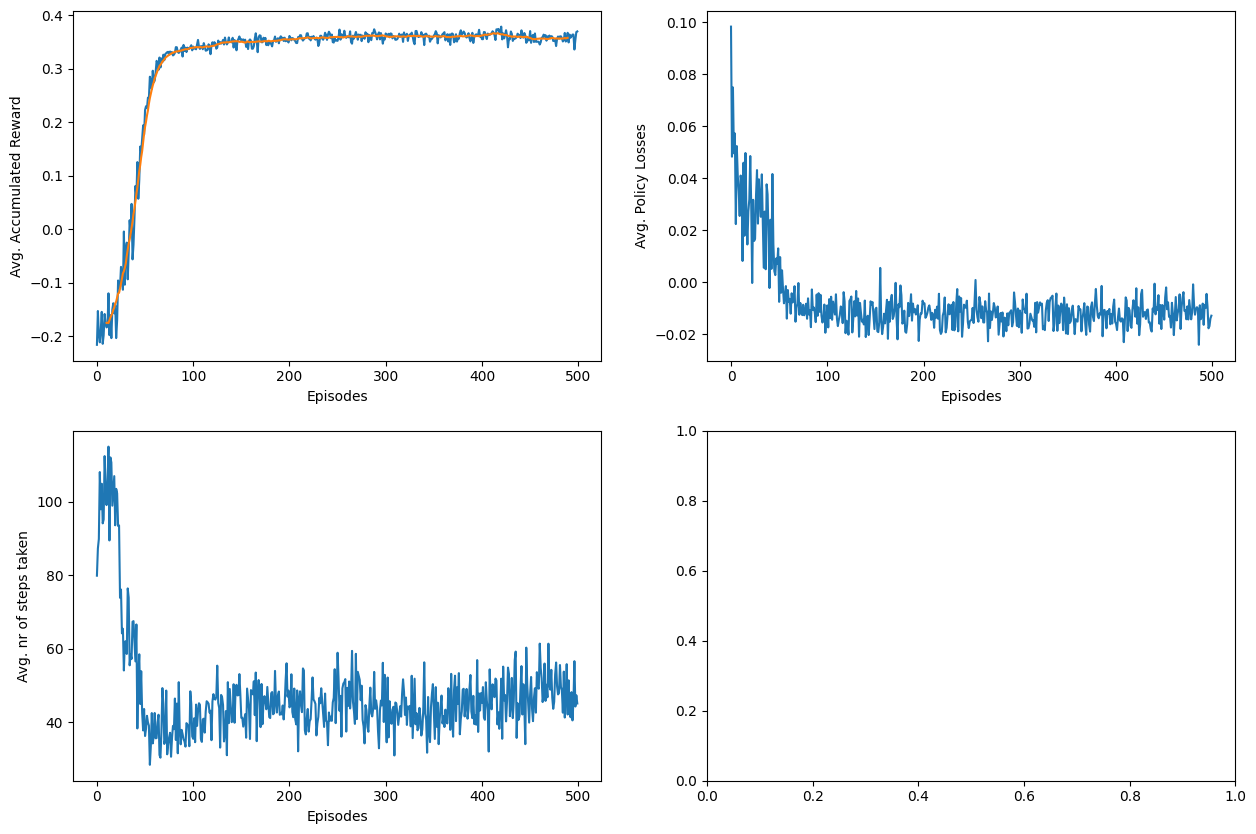

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot([e for e in range(len(rewards))], rewards)
ax[0,0].plot(range(10,len(rewards)-10),[np.mean(rewards[e-10:e+10]) for e in range(10,len(rewards)-10)])
ax[0,0].set_xlabel('Episodes')
ax[0,0].set_ylabel('Avg. Accumulated Reward')

ax[0,1].plot([e for e in range(len(policy_losses))], policy_losses)
ax[0,1].set_xlabel('Episodes')
ax[0,1].set_ylabel('Avg. Policy Losses')

ax[1,0].plot([e for e in range(len(nr_steps))], nr_steps)
ax[1,0].set_xlabel('Episodes')
ax[1,0].set_ylabel('Avg. nr of steps taken')

ax[1,1].plot([e for e in range(len(value_losses))], value_losses)
ax[1,1].set_xlabel('Episodes')
ax[1,1].set_ylabel('Avg. Value Losses')
plt.show()